<a href="https://colab.research.google.com/github/ml2-picme/PicMe/blob/master/Find_Images_In_Google_Drive_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This Notebook loads the content of the shared Google Drive directory into the lokal session storage

### 1. Load the content of the Drive directory into local storage

In [1]:
# Install the PyDrive wrapper & import libraries
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Delete the local directory
!rm -r /root/data/
print("Deleted local directory")

# Set a local directory and upload files from Google Drive
local_root_path = os.path.expanduser("~/data")
try:
  os.makedirs(local_root_path)
except: pass

def ListFolder(google_drive_id, destination):
  file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % google_drive_id}).GetList()
  counter = 0
  for f in file_list:
    # If it is a directory then, create the dicrectory and upload the file inside it
    if f['mimeType']=='application/vnd.google-apps.folder': 
      folder_path = os.path.join(destination, f['title'])
      os.makedirs(folder_path)
      print('* creating directory {}'.format(folder_path))
      ListFolder(f['id'], folder_path)
    else:
      fname = os.path.join(destination, f['title'])
      f_ = drive.CreateFile({'id': f['id']})
      f_.GetContentFile(fname)
      counter += 1
  print('* {} files were uploaded in {}'.format(counter, destination))

# Opening and uploading the Drive Folder => this is the shared directory and should work for everyone who belongs to the project
print("\nCalling the ListFolder method, that uploads the data...")
ListFolder("1PTOfzcdMkVn5bTJ6nhGALQO8ICGBGbnc", local_root_path)
print("Upload finished!")

# Show the Data in the local Path
print("\nListing files in local test directory")
!ls -l /root/data/test_images

    100% |████████████████████████████████| 993kB 18.3MB/s 
rm: cannot remove '/root/data/': No such file or directory
Deleted local directory

Calling the ListFolder method, that uploads the data...
* creating directory /root/data/test_images
* 8 files were uploaded in /root/data/test_images
* 0 files were uploaded in /root/data
Upload finished!

Listing files in local test directory
total 1076
-rw-r--r-- 1 root root 106647 Mar 28 09:41 auto.jpg
-rw-r--r-- 1 root root 204846 Mar 28 09:41 berge.jpg
-rw-r--r-- 1 root root 104237 Mar 28 09:41 brücke.jpg
-rw-r--r-- 1 root root 118569 Mar 28 09:41 handy.jpg
-rw-r--r-- 1 root root  51903 Mar 28 09:41 hund.jpg
-rw-r--r-- 1 root root  53904 Mar 28 09:41 papagei.jpg
-rw-r--r-- 1 root root  97310 Mar 28 09:41 sandwich.jpg
-rw-r--r-- 1 root root 346140 Mar 28 09:41 waffe.jpg


### 2. Make a list of paths for the image files in this directory (and it's subdirectories)

In [2]:
import os

path = '/root/data'

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if file.endswith(".jpg"):
            files.append(os.path.join(r, file))
            
print("Printing files:")

for f in files:
    print(f)

Printing files:
/root/data/test_images/waffe.jpg
/root/data/test_images/auto.jpg
/root/data/test_images/hund.jpg
/root/data/test_images/handy.jpg
/root/data/test_images/berge.jpg
/root/data/test_images/papagei.jpg
/root/data/test_images/sandwich.jpg
/root/data/test_images/brücke.jpg


### 3. Classify the Images using pre-trained model

In [0]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

from PIL import Image
import urllib.request

# load the model
model = VGG16()

for f in files:
    # load an image from file
    image = load_img(f, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # predict the probability across all output classes
    yhat = model.predict(image)
    # convert the probabilities to class labels
    label = decode_predictions(yhat)
    # retrieve the most likely result, e.g. highest probability
    label = label[0][0]
    # print the classification
    print("Following classes were predicted:")
    
    load_img(f)
    
    
    
    print('%s --> %s (%.2f%%)' % (f, label[1], label[2]*100))

40960/35363 [==================================] - 0s 0us/step
/root/data/test_images/auto.jpg --> sports_car (59.34%)
/root/data/test_images/brücke.jpg --> steel_arch_bridge (96.87%)
/root/data/test_images/papagei.jpg --> macaw (99.62%)
/root/data/test_images/handy.jpg --> iPod (53.37%)
/root/data/test_images/hund.jpg --> Labrador_retriever (49.45%)
/root/data/test_images/berge.jpg --> alp (66.41%)
/root/data/test_images/waffe.jpg --> revolver (81.78%)
/root/data/test_images/sandwich.jpg --> French_loaf (41.49%)


# Einlesen von Bildern und Klassifizierung der Top 5 Ergebnisse 
Der Code setzt das selbe Problem wie oben um, nur in einer etwas anderen Form.

In [0]:
# Einlesen der Daten

import os
import numpy as np
from tqdm import tqdm_notebook as tqdm
from PIL import Image

def read_images(path):
    files = os.listdir(path)
    files = [file for file in files if file[-4:] == ".jpg"]
    
    # files = files[:2000]
    
    images = []
    for file in tqdm(files):
        try:
            image = Image.open(os.path.join(path, file))

            # https://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.resize
            image = image.resize((224, 224), Image.LANCZOS)

            # https://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.convert
            image = image.convert("RGB")

            image = np.asarray(image)

            images.append(image)
        except OSError:
            pass
    
    return images

In [48]:

images = read_images(os.path.join("/root", "data", "test_images"))
images = np.asarray(images)

**Hier kann das jeweilige Netz ausgetauscht werden**

Vorgehen:


*  Import anpassen
*  ideale shape der Bilder recherchieren -> https://keras.io/applications/
* Code anpassen



In [49]:
from keras.applications.vgg16 import VGG16, preprocess_input
# load the model
vgg16_model = VGG16(input_shape=(224, 224, 3))
# preprocess the images to fit to the model
images_preprocessed = preprocess_input(images)
# use the model to classifi the images
images_pred = vgg16_model.predict(images_preprocessed, verbose=1)


8/8 [==============================] - 0s 35ms/step


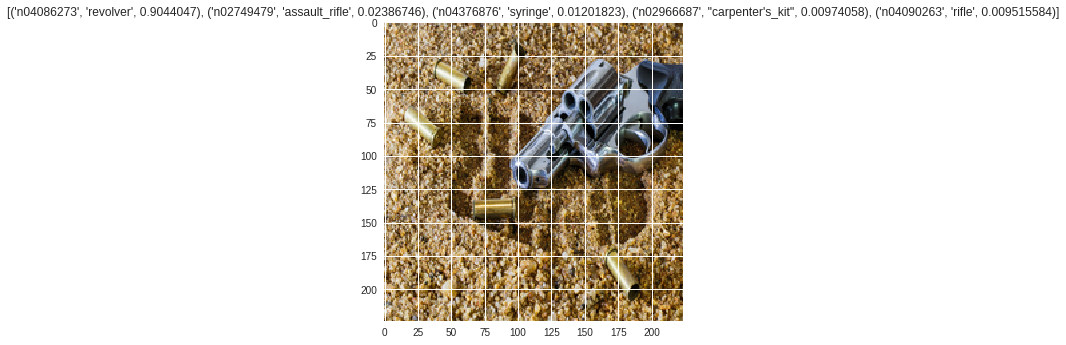

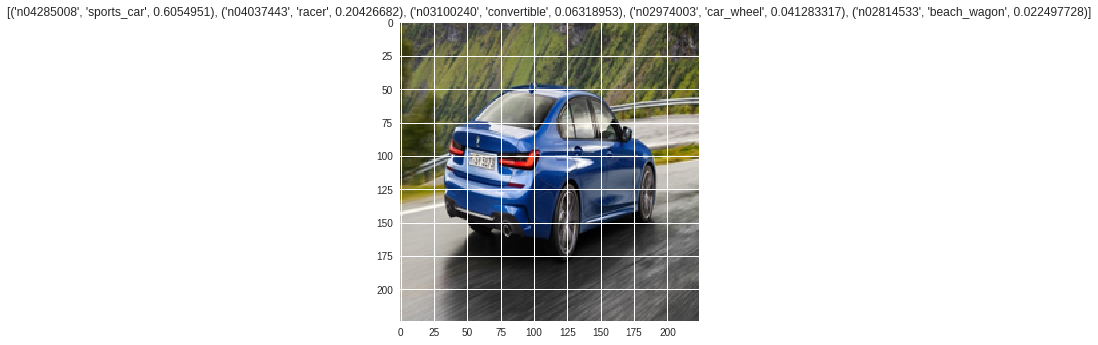

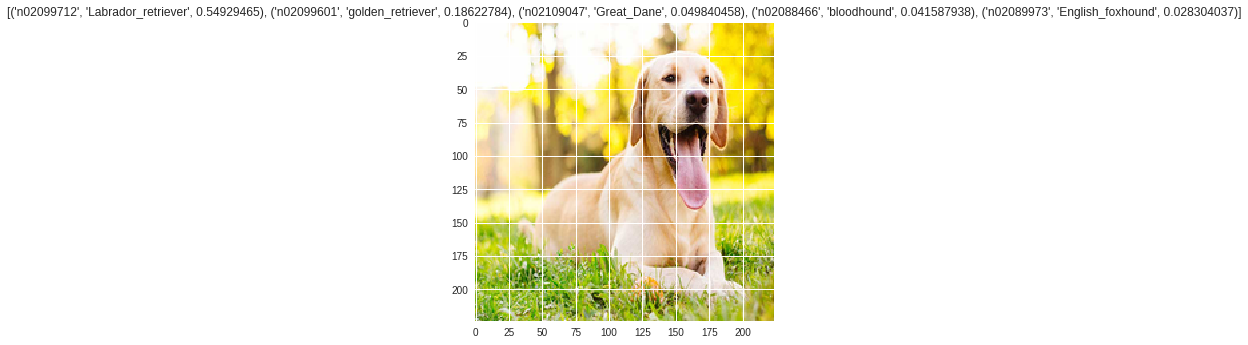

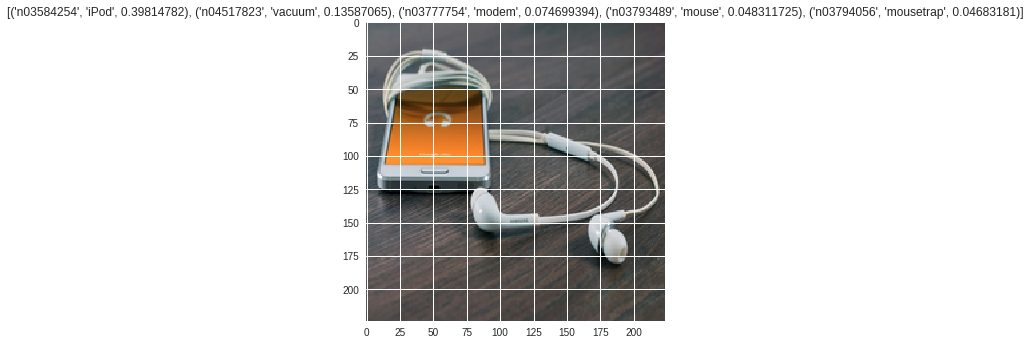

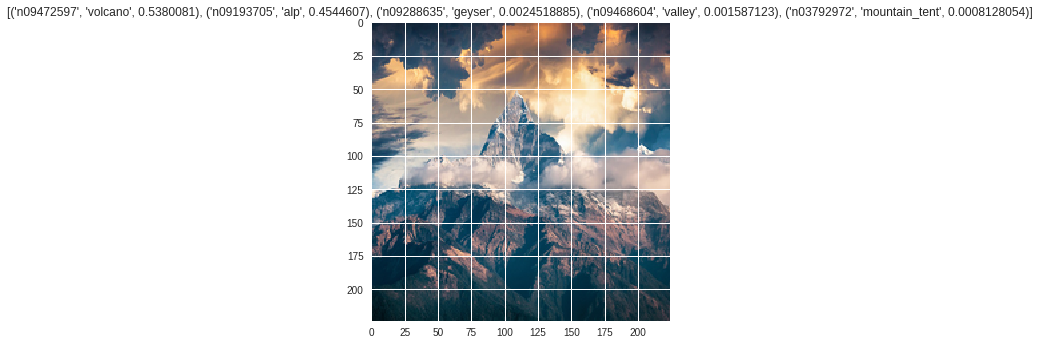

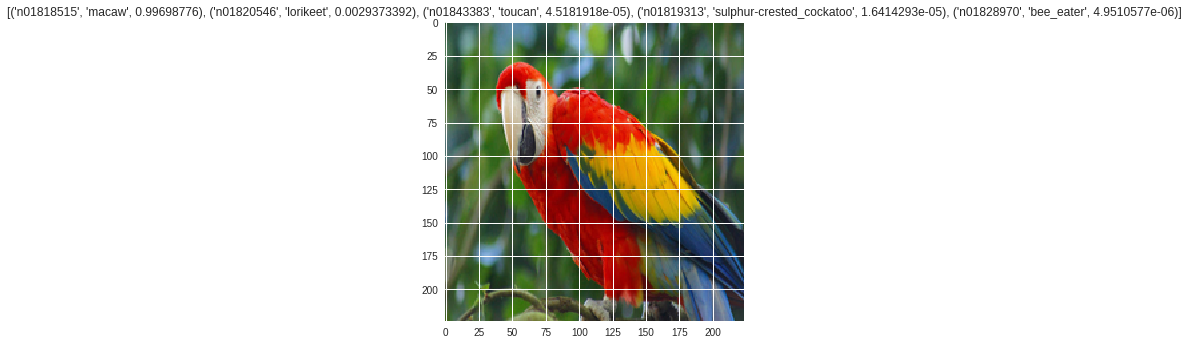

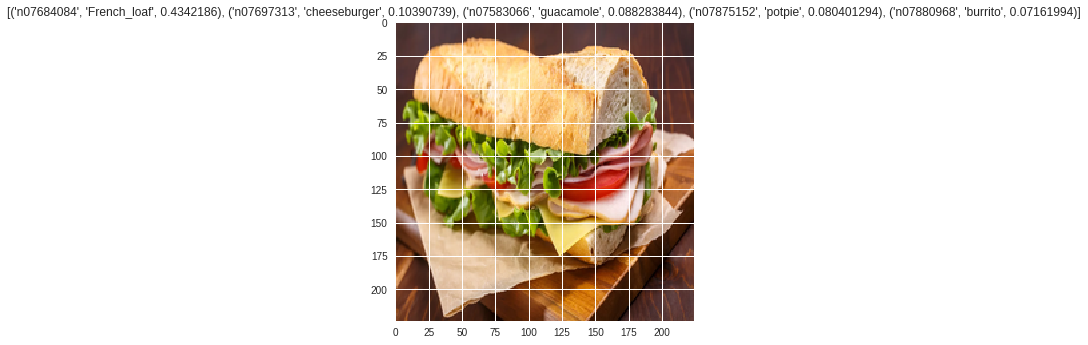

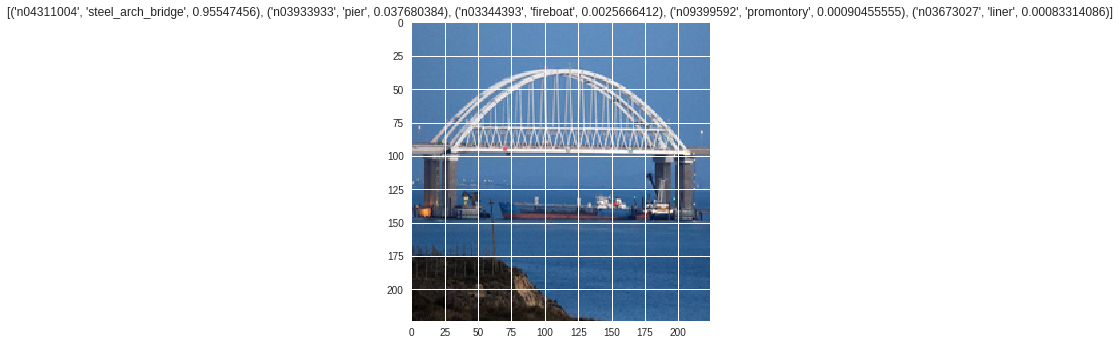

In [50]:
from keras.applications.vgg16 import decode_predictions
import matplotlib.pyplot as plt
pred_results = decode_predictions(images_pred)
i = 0
for image in images:
  plt.figure()
  plt.imshow(image)
  plt.title(pred_results[i])
  i = i+1
 
plt.show()